<font size = "5"> **EELS_Tools:  [Spectroscopy](Ch4-Spectroscopy.ipynb)** </font>

<hr style="height:1px;border-top:4px solid #FF8200" />

# Analysis of Core-Loss EELS Spectra
<br>


[Download](https://raw.githubusercontent.com/pycroscopy/pyTEMlib/main/notebooks/EELS/Analysis_Core_Loss.ipynb)
 
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](
    https://colab.research.google.com/github/pycroscopy/pyTEMlib/blob/main/notebooks/EELS/Analysis_Core_Loss.ipynb)
    
part of 

<font size = "5"> **[pyTEMlib](https://pycroscopy.github.io/pyTEMlib/about.html)**</font>

a [pycroscopy](https://pycroscopy.github.io/pycroscopy/about.html) ecosystem package


Notebook by Gerd Duscher, 2023

Microscopy Facilities<br>
Institute of Advanced Materials & Manufacturing<br>
The University of Tennessee, Knoxville

Model based analysis and quantification of data acquired with transmission electron microscopes




## Content

Quantitative determination of chemical composition from a core-loss EELS spectrum


Relavant notebooks in course [MSE 672: Introduction to TEM]()  give an in depth explanation of the method.

Please cite:

[M. Tian et  al. *Measuring the areal density of nanomaterials by electron energy-loss spectroscopy*
Ultramicroscopy Volume 196, 2019, pages 154-160](https://doi.org/10.1016/j.ultramic.2018.10.009)

as a reference of this quantification method.

## Prerequesites
This notebook will only run with  ``version 0.2022.6.0`` or higher.

### Install missing packages
This can take a while for the first time. This code will have to run at least once on you computer or colab session.

In [1]:
import sys

from pkg_resources import get_distribution, DistributionNotFound

def test_package(package_name):
    """Test if package exists and returns version or -1"""
    try:
        version = (get_distribution(package_name).version)
    except (DistributionNotFound, ImportError) as err:
        version = '-1'
    return version


# pyTEMlib setup ------------------
if test_package('pyTEMlib') < '0.2023.5.0':
    print('installing pyTEMlib')
    !{sys.executable} -m pip install git+https://github.com/pycroscopy/SciFiReaders.git@main -q
    !{sys.executable} -m pip install git+https://github.com/pycroscopy/pyTEMlib.git@main -q
    
# ------------------------------
print('done')

done


### Load the relevant packages

In [1]:
%matplotlib ipympl
import numpy as np
import matplotlib.pylab as plt 
import sys

if 'google.colab' not in sys.modules:
    %gui qt5
    

# sys.path.insert(0, '../../')

import pyTEMlib
import pyTEMlib.file_tools as ft     # File input/ output library
import pyTEMlib.image_tools as it
import pyTEMlib.eels_tools  as eels        # EELS methods 

import pyTEMlib.interactive_eels as ieels  # Dialogs for EELS input and quantification

# For archiving reasons it is a good idea to print the version numbers out at this point
print('pyTEMlib version: ', pyTEMlib.__version__)
if pyTEMlib.__version__ < '0.2023.3.0':
    print('This version of pyTEMlib will not work with this notebook')
    print('Please install new pyTEMlib version with code cell above first and then restart this notebook!')
    
__notebook__ = 'analyze_core_loss'
__notebook_version__ = '2023_03_20'


if 'google.colab' in sys.modules:
    drive.mount("/content/drive")

You don't have igor2 installed.     If you wish to open igor files, you will need to install it     (pip install igor2) before attempting.
You don't have gwyfile installed.     If you wish to open .gwy files, you will need to      install it (pip install gwyfile) before attempting.
Symmetry functions of spglib enabled
pyTEMlib version:  0.2023.5.0


## Load and plot a spectrum

As an example we load the spectrum **1EELS Acquire (high-loss).dm3** from the *example data* folder.

Please see [Loading an EELS Spectrum](LoadEELS.ipynb) for details on storage and plotting.

First a dialog to select a file will apear.

Then the spectrum plot and ``Spectrum Info`` dialog will appear, in which we set the experimental parameters.

Please use the ``Set Energy Scale`` button to change the energy scale. When pressed a new dialog and a cursor will appear in which one is able to set the energy scale based on known features in the spectrum.


In [7]:
# -----Input -------#
load_example = True

if load_example:
    datasets = ft.open_file('../../example_data/EELS_STO.hf5')
else:
    datasets = ft.open_file()
#ft.add_dataset_from_file(datasets, '../example_data/1EELS Acquire (low-loss).dm3', 'Reference')
#datasets['Reference_000'].metadata['experiment']['exposure_time'] = datasets['Reference_000'].metadata['experiment']['single_exposure_time'] * datasets['Reference_000'].metadata['experiment']['number_of_frames']
info = ieels.InfoWidget(datasets)


edges
0
all_edges
L1
L2
L3
1
all_edges
K1
fit_area
model
experiment
DM
DocumentObjectList
0
AnnotationGroupList
ImageDisplayInfo
CalibrationSliceId
DimensionLabels
GroupList
0
GroupToDisplay
MainSliceId
SliceList
0
ImageToGroup
SliceId
ObjectTags
DocumentTags
Image Behavior
UnscaledTransform
ZoomAndMoveTransform
ImageData
Calibrations
Brightness
Dimension
0
Dimensions
ImageSourceList
0
Extra Slice Info
0
Id
Id
ImageTags
Acquisition
Device
CCD
Configuration
Transpose
Frame
Area
Transform
Transform List
0
Transpose
CCD
Intensity
Transform
Transform List
0
1
Parameters
Base Detector
Detector
Environment
High Level
Shutter
Transform
Objects
0
EELS
Acquisition
Experimental Conditions
EELS Spectrometer
Meta Data
Microscope Info
Session Info
Items
0
1
2
MinVersionList
0
Page Behavior
PageTransform
SentinelList
Thumbnails
0
UniqueID


AppLayout(children=(GridspecLayout(children=(Dropdown(description='Main Dataset:', layout=Layout(grid_area='wi…

In [5]:
filename='../../example_data/EELS_STO.hf5'

datasets=  ft.open_file(filename=filename)
chooser = ft.ChooseDataset(datasets)

edges
0
all_edges
L1
L2
L3
1
all_edges
K1
fit_area
model
experiment
DM
DocumentObjectList
0
AnnotationGroupList
ImageDisplayInfo
CalibrationSliceId
DimensionLabels
GroupList
0
GroupToDisplay
MainSliceId
SliceList
0
ImageToGroup
SliceId
ObjectTags
DocumentTags
Image Behavior
UnscaledTransform
ZoomAndMoveTransform
ImageData
Calibrations
Brightness
Dimension
0
Dimensions
ImageSourceList
0
Extra Slice Info
0
Id
Id
ImageTags
Acquisition
Device
CCD
Configuration
Transpose
Frame
Area
Transform
Transform List
0
Transpose
CCD
Intensity
Transform
Transform List
0
1
Parameters
Base Detector
Detector
Environment
High Level
Shutter
Transform
Objects
0
EELS
Acquisition
Experimental Conditions
EELS Spectrometer
Meta Data
Microscope Info
Session Info
Items
0
1
2
MinVersionList
0
Page Behavior
PageTransform
SentinelList
Thumbnails
0
UniqueID


Dropdown(description='select dataset:', options=('Channel_000: 01_EELS Acquire_STO',), value='Channel_000: 01_…

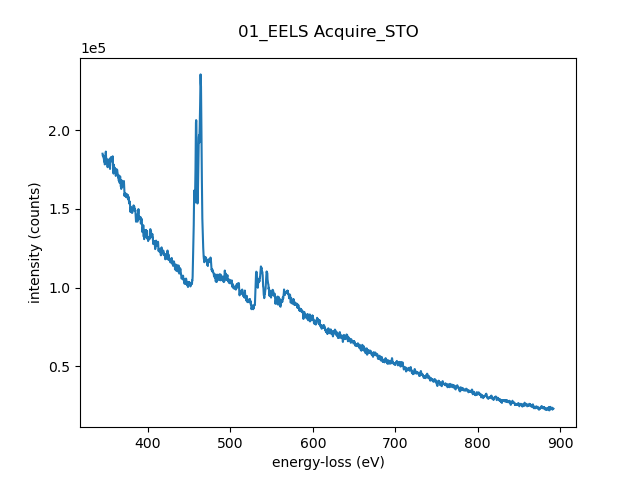

In [3]:
dataset = chooser.dataset
view = dataset.plot()
plt.show() 
plt.draw()

## Chemical Composition 
The fit of the cross-section and background to the spectrum results in the chemical composition. If the calibration is correct this composition is given as areal density in atoms/nm$^2$




In [9]:
print('Auto Quantification')
eels.auto_chemical_composition(datasets['Channel_000'])

Auto Quantification

Relative composition: 
Ti: 18.8%  O: 81.2%  


###  Fit of Data
A dialog window will open, enter the elements first (0 will open a periodic table) and press 
``Fit Composition`` button (bottom right). Adjust parameters as needed and check fit by pressing the ``Fit Composition`` button again.

Select the ``Region`` checkbox to see which parts of the spectrum you choose to fit.

Changing the multiplier value will make a simulation of your spectrum.

The ``InfoDialog``, if open, still works to change experimental parameters and the energy scale.

In [12]:
composition = ieels.CompositionWidget(datasets)

AppLayout(children=(GridspecLayout(children=(Button(description='Fit Area', layout=Layout(grid_area='widget001…

### Output of Results

In [15]:
edges = datasets['Channel_000'].metadata['edges']
element = []
areal_density = []
for key, edge in edges.items():
    if key.isdigit():
        element.append(edge['element'])
        areal_density.append(edge['areal_density'])

print('Relative chemical composition of ', datasets['Channel_000'].title)
for i in range(len(element)):
    print(f'{element[i]}: {areal_density[i]/np.sum(areal_density)*100:.1f} %')
    
saved_edges_metadata = edges

Relative chemical composition of  01_EELS Acquire_STO
Ti: 18.8 %
O: 81.2 %


### Log Data
All the data associated with quantification are stored in the ``metadata`` attribute. The relevant keys of that dictionary are:  ``experiment`` and  ``edges``.

In [10]:
dataset.metadata.keys()

dict_keys(['experiment', 'filename', 'edges'])

In [11]:
dataset.metadata

{'experiment': {'single_exposure_time': 2.0,
  'exposure_time': 20.0,
  'number_of_frames': 10,
  'collection_angle': 33.0,
  'convergence_angle': 30.0,
  'acceleration_voltage': 200000.0,
  'offset': 350.0,
  'dispersion': 0.25,
  'binning': 1,
  'conversion': 1.0,
  'flux_ppm': -1.0,
  'flux_unit': 'counts',
  'current': 1.0,
  'SI_bin_x': 1,
  'SI_bin_y': 1},
 'filename': 'C:/Users/gduscher/Documents/Github/pyTEMlib/example_data/EELS_STO.dm3',
 'edges': {'model': {'background': array([169020.25174338, 168789.78918192, 168559.82605639, ...,
            9149.54959508,   9100.75462706,   9051.94875424]),
   'background-poly_0': -81470.80833794757,
   'background-poly_1': 249.6292062065052,
   'background-poly_2': -0.21422944630842575,
   'background-A': 12172261631.904371,
   'background-r': 1.8899156398038295,
   'spectrum': array([176470.83278946, 176223.47467571, 175976.61599788, ...,
           13245.7753568 ,  13191.95820283,  13138.13014407]),
   'blurred': array([183081.86 , 183

Could not find no edge of 1 in spectrum
Could not find no edge of 1 in spectrum


## ELNES
The electron energy-loss near edge structure is determined by fititng the spectrum after quantification model subtraction. 

First smooth the spectrum (only 0 iteration available at this time) and then 
find the number of peaks you want (Can be repeated as oftern as one wants).

Please note that the peaks do not necessarily have a physcial meaning as there are peaks with 
positive and negative amplitudes. The goal is to get a smooth representation of the spectrum.
A difference of a good fit and the data should result in a residual of noise only. To achieve such a good fit, the careful setting of the edge onset is important.


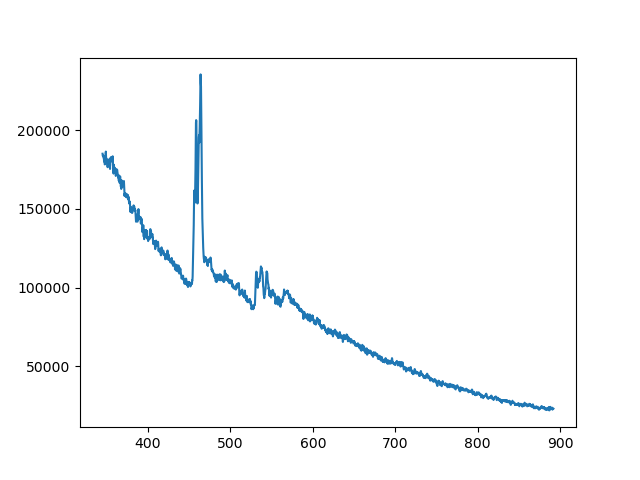

In [19]:
peak_dialog = ieels.PeakFitDialog(datasets['Channel_000'])

### Output

In [ ]:
areas = []
for p, peak in peak_dialog.peaks['peaks'].items():
    area = np.sqrt(2* np.pi)* peak['amplitude'] * np.abs(peak['width'] / np.sqrt(2 *np.log(2))) 
    areas.append(area)
    if 'associated_edge' not in peak:
        peak['associated_edge']= ''
    print(f"peak  {p}: position: {peak['position']:7.1f}, area: {area:12.3f} associated edge: {peak['associated_edge']}")
#print(f'\n M4/M5 peak 2 to peak 1 ratio: {(areas[1])/areas[0]:.2f}')

### Log Data
All the data associated with quantification are stored in the ``metadata`` attribute. 
The new key in that dictionary is: ``peak_fit``.

In [ ]:
dataset.metadata.keys()

## Save and Close File
The dataset with the metadata should be saved for further quantification. 
The file needs to be closed to be used with other notebooks.

In [ ]:
h5_group = ft.save_dataset(datasets, '../../example_data/EELS_STO.hf5')
h5_group.file.close()